<a href="https://colab.research.google.com/github/Dworlock11/Exoplanet-Machine-Learning-Analysis/blob/main/Exoplanet_Habitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Statements

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, make_scorer, classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
from warnings import simplefilter

df = pd.read_excel("/content/drive/MyDrive/College and Work/Exoplanet Catalog.xlsx")
# df = pd.read_excel("exoplanet_catalog.xlsx")
pd.set_option('display.max_columns', None)
df

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,P_ATMOSPHERE,S_NAME,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_METALLICITY,S_METALLICITY_ERROR_MIN,S_METALLICITY_ERROR_MAX,S_MASS,S_MASS_ERROR_MIN,S_MASS_ERROR_MAX,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TYPE,S_AGE,S_AGE_ERROR_MIN,S_AGE_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_DISC,S_MAGNETIC_FIELD,S_LOG_G,S_ALT_NAMES,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,P_TYPE,S_RADIUS_EST,S_TYPE_TEMP,S_RA_H,S_RA_T,S_DEC_T,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007.0,2014-05-14,326.030000,-0.320,0.320,1.29000,-0.050,0.050,0.231,-0.005,0.005,NaN,NaN,NaN,94.8,-1.5,1.5,2452899.6,-1.6,1.6,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 Com,185.179280,17.792868,4.740,93.37,-1.92,1.92,-0.35,-0.09,0.09,2.70,-0.300,0.300,19.000000,-2.000,2.000,K0 III,NaN,NaN,NaN,4742.0,-100.0,100.0,NaN,NaN,2.31,"HD 107383, HIP 60202",NaN,NaN,NaN,NaN,0.130671,1.324418,0.99201,1.58799,1.298759,101.011410,64.855456,166.191940,799.44963,722.98875,914.73942,Jovian,19.000000,K,12.345286,12 20 43.0286,+17 47 34.3248,163.546800,10.132812,24.763411,12.834754,23.477907,13.586847,23.477907,12.390643,23.477907,34.529063,0.476460,0.642400,0.0,0.0,Hot,0.0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009.0,2018-09-06,516.219970,-3.200,3.200,1.53000,-0.070,0.070,0.080,-0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 UMi,229.274540,71.823898,5.016,125.72,-1.97,1.97,-0.02,NaN,NaN,2.78,-0.690,0.690,29.790000,-2.840,2.840,K4 III,NaN,NaN,NaN,4213.0,-46.0,46.0,NaN,NaN,1.93,"HD 136726, HIP 74793",NaN,NaN,NaN,NaN,0.167551,1.534896,1.40760,1.65240,1.531227,107.351180,91.741348,126.426170,819.07569,788.47184,854.28770,Jovian,29.790000,K,15.284970,15 17 05.8915,+71 49 26.0328,250.492940,12.770059,31.984271,16.175280,30.323783,17.134143,30.323783,15.615215,30.323783,42.732816,0.193891,0.648683,0.0,0.0,Hot,0.0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008.0,2014-05-14,185.840000,-0.230,0.230,0.83000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2452861.4,-1.5,1.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,14 And,352.822570,39.236198,5.227,75.59,-0.71,0.71,-0.24,-0.03,0.03,2.20,-0.200,0.100,11.000000,-1.000,1.000,G8 III,NaN,NaN,NaN,4813.0,-20.0,20.0,NaN,NaN,2.63,"HD 221345, HIP 116076",NaN,NaN,NaN,NaN,0.073485,0.830000,0.83000,0.83000,0.830000,84.446427,84.446427,84.446427,772.30746,772.30746,772.30746,Jovian,11.000000,G,23.521506,23 31 17.4215,+39 14 10.3128,58.175144,6.025230,14.680087,7.631867,13.918028,8.078404,13.918028,7.367780,13.918028,20.593611,0.502752,0.600010,0.0,0.0,Hot,0.0,0.081917,Andromeda,And,And

In [3]:
classification_scores = []
regression_scores = []

# Preprocessing

When a value in the column "P_HABITABLE" equals "2", it that planet is potentially habitable under conservative estimates. For the purposes of allowing binary classification, conservative and liberal estimates will both simply be considered "potentially habitable".

In [4]:
df["P_HABITABLE"] = df["P_HABITABLE"].mask(df["P_HABITABLE"] == 2, 1)
df["P_HABITABLE"].value_counts()

,count
P_HABITABLE,
0.0,3993
1.0,55


As many of the columns from the dataset contain a lot of null entries, it is best to simply remove them. All columns with the number of null values greater than a quarter the length of the dataset are removed.

In [5]:
col_non_null_count = df.isna().sum()
cols_non_majority_null = col_non_null_count[col_non_null_count < len(df)/4].index.to_list()
df = df[cols_non_majority_null]

Additional feature selection is conducted, as many of the features are unhelpful for model training, are copies of one another, or are close in value. In particular, P_ESI is removed, since ESI (Earth Similarity Index) is already an artificially constructed metric of habitability and thus will most likely be highly correlated with habitability.

In [6]:
df = df.drop(["P_NAME", "P_STATUS", "P_RADIUS", "P_YEAR", "P_UPDATED", "S_NAME", "S_RADIUS", "S_ALT_NAMES", "P_HABZONE_OPT", "P_HABZONE_CON", "S_CONSTELLATION_ABR", "P_PERIOD_ERROR_MIN", "P_PERIOD_ERROR_MAX", "S_DISTANCE_ERROR_MIN", "S_DISTANCE_ERROR_MAX", "P_FLUX_MIN", "P_FLUX_MAX", "P_TEMP_EQUIL_MIN", "P_TEMP_EQUIL_MAX", "P_ESI"], axis=1)
df.shape

(4049, 47)

Categorical features with far too many unique values are removed to simplify the model after encoding.

In [7]:
num_features = df.select_dtypes(include=np.number)
cat_features = df.select_dtypes(exclude=np.number)

for col in cat_features.columns:
  print(col, "-", len(cat_features[col].value_counts()))

df = df.drop(["S_RA_T", "S_DEC_T", "S_CONSTELLATION", "S_CONSTELLATION_ENG"], axis=1)

P_DETECTION - 10
P_TYPE - 6
S_TYPE_TEMP - 7
S_RA_T - 3010
S_DEC_T - 3010
P_TYPE_TEMP - 3
S_CONSTELLATION - 88
S_CONSTELLATION_ENG - 88


The data is checked for the skew of each feature to determine the appropriate imputing method. Since the data is heavily skewed, the median will be chosen.

In [8]:
df.skew(axis=0, numeric_only=True, skipna=True)

,0
P_RADIUS_ERROR_MIN,-25.485833
P_RADIUS_ERROR_MAX,22.566295
P_PERIOD,62.170001
S_RA,-1.431541
S_DEC,-1.193701
S_MAG,-1.102203
S_DISTANCE,5.045452
S_MASS,17.228769
S_MASS_ERROR_MAX,45.649624
S_RADIUS_ERROR_MIN,-32.113850


The proportion of classes of the target is determined to know which scoring metrics to use.

In [9]:
unhabitable = df["P_HABITABLE"].value_counts()[0]
habitable = df["P_HABITABLE"].value_counts()[1]

print("Percentage of planets that are unhabitable: ", unhabitable/(unhabitable+habitable))
print("Percentage of planets that are habitable: ", habitable/(unhabitable+habitable))

Percentage of planets that are unhabitable:  0.9864130434782609
Percentage of planets that are habitable:  0.01358695652173913


There is a heavy class imbalance. Since detecting habitable planets is crucial, recall is the fitting score.

# Logistic Regression

The data is separated into the features and the target.

In [10]:
X = df.drop(["P_HABITABLE"], axis=1)
y = df["P_HABITABLE"]

All rows where the target value is null are removed.

In [11]:
y_na = y[y.isna()]
data = X.join(y)
data = data.drop(y_na.index)
X = data.drop("P_HABITABLE", axis=1)
y = data["P_HABITABLE"]
print(y.isna().sum())

0


The data is split into the training and testing data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

Transformers for numerical and categorical data are created.

In [13]:
# Separate numerical and categorical features
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Build transformers
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformers
log_preprocessor = ColumnTransformer([
        ("num_transformer", num_transformer, num_col_names),
        ("cat_transformer", ohe_transformer, cat_col_names)
    ]
)

The pipeline is created and hyperparameter tuning is implemented. Since correct classification of habitable planets is crucial, hyperparameters are optimized for recall of the positive class.

In [22]:
log_pipe = Pipeline([
    ("log_preprocessor", log_preprocessor),
    ("log_reg", LogisticRegression())
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

param_distributions = [
    # {   # For lbfgs
    #     'log_reg__penalty': ['l2'],
    #     'log_reg__solver': ['lbfgs'],
    #     'log_reg__C': np.logspace(-4, 4, 20),
    #     'log_reg__max_iter': [200, 500, 1000],
    #     'log_reg__class_weight': ['balanced', None]
    # },
    # {   # For liblinear
    #     'log_reg__penalty': ['l1', 'l2'],
    #     'log_reg__solver': ['liblinear'],
    #     'log_reg__C': np.logspace(-4, 4, 20),
    #     'log_reg__max_iter': [200, 500, 1000],
    #     'log_reg__class_weight': ['balanced', None]
    # },
    # {   # For saga and L1, L2
    #     'log_reg__penalty': ['l1', 'l2'],
    #     'log_reg__solver': ['saga'],
    #     'log_reg__C': np.logspace(-4, 4, 20),
    #     'log_reg__max_iter': [200, 500, 1000],
    #     'log_reg__class_weight': ['balanced', None]
    # },
    # {
    #     # For saga and ElasticNet
    #     'log_reg__penalty': ['elasticnet'],
    #     'log_reg__solver': ['saga'],
    #     'log_reg__l1_ratio': np.linspace(0, 1, 5),
    #     'log_reg__C': np.logspace(-4, 4, 20),
    #     'log_reg__max_iter': [200, 500, 1000],
    #     'log_reg__class_weight': ['balanced', None]
    # }

    "log_reg__solver" : ["saga"]
    "log_reg__penalty" : ["l2"]
    "log_reg__max_iter" : [500]
    "log_reg__class_weight" : ["balanced"]
    "log_reg__C" : [0.23357214690901212]
]

recall_pos = make_scorer(recall_score, pos_label=1)
search = RandomizedSearchCV(log_pipe, param_distributions=param_distributions, n_iter=50, cv=kf, random_state=7, scoring=recall_pos,
    n_jobs=-1)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-2367888036.py, line 30)

The model is trained, tested, and scored with a classification report.

In [15]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)
y_pred = best_model.predict(X_test)
log_reg_score = recall_score(y_test, y_pred)
classification_scores.append(log_reg_score)

log_reg__solver : saga
log_reg__penalty : l2
log_reg__max_iter : 500
log_reg__class_weight : balanced
log_reg__C : 0.23357214690901212


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       799
         1.0       0.58      1.00      0.73        11

    accuracy                           0.99       810
   macro avg       0.79      0.99      0.86       810
weighted avg       0.99      0.99      0.99       810



The weighted F1 score is close to perfect. However, as expected, the score specifically for the positive class is lower. Evidently, the worse predicting capabilities of the model for the positve class are obscured due to the extreme class imbalance. Additionally, since hyperparameters were optimized based on recall for the positive class, that score is perfect, but precision for the positive class is significantly lower, leading to the lower F1 score for the positive class compared to the negative class.

Permutation importance is used to find the most important features.

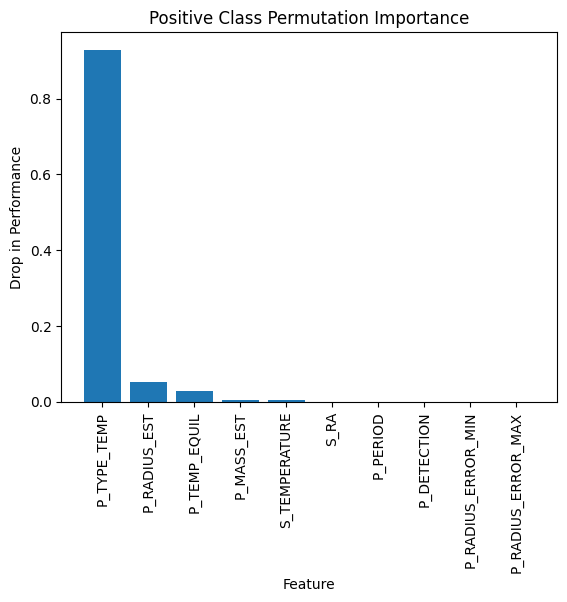

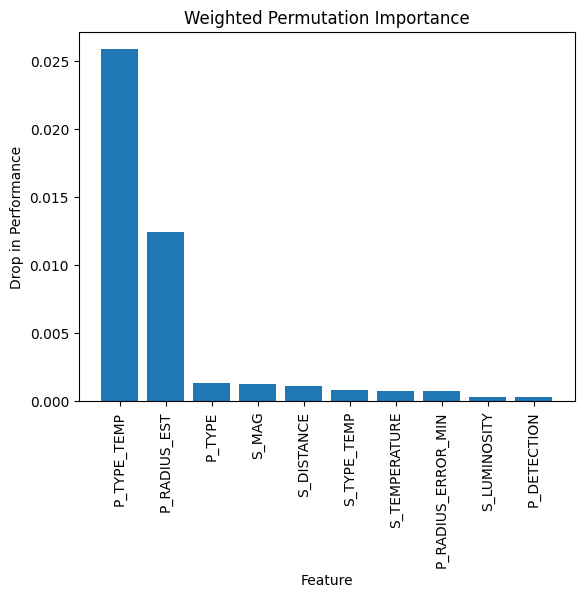

In [17]:
class1_result = permutation_importance(best_model, X_test, y_test, scoring=recall_pos, n_repeats=50, random_state=7, n_jobs=-1)
class1_importances = pd.Series(class1_result.importances_mean, index=X_test.columns).sort_values(ascending=False).head(10)

plt.bar(x=class1_importances.index, height=class1_importances.values)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.title("Positive Class Permutation Importance")
plt.show()

recall_weighted = make_scorer(recall_score, average="weighted")
weighted_result = permutation_importance(best_model, X_test, y_test, scoring=recall_weighted, n_repeats=30, random_state=7, n_jobs=-1)
weighted_importances = pd.Series(weighted_result.importances_mean, index=X_test.columns).sort_values(ascending=False).head(10)

plt.bar(x=weighted_importances.index, height=weighted_importances.values)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.title("Weighted Permutation Importance")
plt.show()

Apparently, the most important feature by far is P_TYPE_TEMP, with P_RADIUS_EST, P_TEMP_EQUIL, P_MASS_EST, and S_TEMPERATURE also contributing. All other features aren't at all important for predicting habitability. It makes sense that the temperature would be a strong predictor of habitability.

However, the degree that the performace worsens after permutation is significantly higher when only considering the positive class. This alligns with the f1_score being lower when scoring only the positive class.

# Decision Tree

Now a decision tree model will be trained.

Transformers for numerical and categorical data are created.

In [18]:
oe_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="error"))
])

# Combine transformers
tree_preprocessor = ColumnTransformer([
        ("num_transformer", num_transformer, num_col_names),
        ("oe_transformer", oe_transformer, cat_col_names)
    ]
)

The pipeline is created and hyperparameter tuning is implemented.

In [19]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeClassifier())
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

param_distributions = [
    {   # For lbfgs
        'log_reg__penalty': ['l2'],
        'log_reg__solver': ['lbfgs'],
        'log_reg__C': np.logspace(-4, 4, 20),
        'log_reg__max_iter': [200, 500, 1000],
        'log_reg__class_weight': ['balanced', None]
    },
    {   # For liblinear
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__solver': ['liblinear'],
        'log_reg__C': np.logspace(-4, 4, 20),
        'log_reg__max_iter': [200, 500, 1000],
        'log_reg__class_weight': ['balanced', None]
    },
    {   # For saga and L1, L2
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__solver': ['saga'],
        'log_reg__C': np.logspace(-4, 4, 20),
        'log_reg__max_iter': [200, 500, 1000],
        'log_reg__class_weight': ['balanced', None]
    },
    {
        # For saga and ElasticNet
        'log_reg__penalty': ['elasticnet'],
        'log_reg__solver': ['saga'],
        'log_reg__l1_ratio': np.linspace(0, 1, 5),
        'log_reg__C': np.logspace(-4, 4, 20),
        'log_reg__max_iter': [200, 500, 1000],
        'log_reg__class_weight': ['balanced', None]
    }

    # {
    #  'log_reg__solver': ['liblinear'],
    #  'log_reg__penalty': ['l2'],
    #  'log_reg__max_iter': [500],
    #  'log_reg__class_weight': [None],
    #  'log_reg__C': [3792.690190732246]
    #  }
]

search = RandomizedSearchCV(pipe, param_distributions=param_distributions, cv=kf, random_state=7)

The model is trained, tested, and scored with the F1 score. Due to the extreme imbalance of the data, two different F1 scores are calculated: one only scoring the positive class and weighted by the classes.

In [20]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)
y_pred = best_model.predict(X_test)

log_reg_score = f1_score(y_test, y_pred)
log_reg_score_weighted = f1_score(y_test, y_pred, average="weighted")
classification_scores.append(log_reg_score)
print("\n", "Class 1 F1 Score: ", log_reg_score, "\n", "Weighted F1 Score: ", log_reg_score_weighted, "\n")

The weighted score is close to perfect. However, as expected, the score specifically for the positive class is lower. Evidently, the worse predicting capabilities of the model for the positve class are obscured due to the extreme class imbalance.

Permutation importance is used to find the most important features.

In [21]:
f1_pos = make_scorer(f1_score, pos_label=1)
class1_result = permutation_importance(best_model, X_test, y_test, scoring=f1_pos, n_repeats=30, random_state=42, n_jobs=-1)
class1_importances = pd.Series(class1_result.importances_mean, index=X_test.columns).sort_values(ascending=False).head(10)

plt.bar(x=class1_importances.index, height=class1_importances.values)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.title("Positive Class Permutation Importance")
plt.show()

f1_weighted = make_scorer(f1_score, average="weighted")
weighted_result = permutation_importance(best_model, X_test, y_test, scoring=f1_weighted, n_repeats=30, random_state=7, n_jobs=-1)
weighted_importances = pd.Series(weighted_result.importances_mean, index=X_test.columns).sort_values(ascending=False).head(10)

plt.bar(x=weighted_importances.index, height=weighted_importances.values)
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.title("Weighted Permutation Importance")
plt.show()

Apparently, the most important features are P_TYPE_TEMP and P_TYPE, with S_RADIUS_ERROR_MIN, P_RADIUS_EST, S_LUMINOSITY, S_MASS_ERROR_MAX, S_TEMPERATURE, and S_LOG_G also contributing. All other features aren't at all important for predicting habitability. It makes sense that the type of planet (Jovian, Terran, etc) and the temperature would be strong predictors of habitability.

However, the degree that the performace worsens after permutation is significantly higher when only considering the positive class. This alligns with the f1_score being lower when scoring only the positive class.